# 머신러닝 기반 외식 서비스(식당) 리뷰 감성 분석 및 만족도 지수 개발

### AI융합학부 20243305 하정훈

---

## 설치 및 환경 구성

In [1]:
%pip install kagglehub
%pip install nltk
%pip install xgboost
%pip install sentence-transformers
%pip install tf-keras

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import sys
import time
import re
import ast
import json
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import kagglehub

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from transformers import pipeline
from sentence_transformers import SentenceTransformer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

---

## Zomato 데이터셋(Kaggle) 불러오기

In [3]:
zomato_path = kagglehub.dataset_download("himanshupoddar/zomato-bangalore-restaurants")
print("파일 경로:", zomato_path)

file_list = os.listdir(zomato_path)
print("폴더 내 파일:", file_list)

파일 경로: C:\Users\하정훈\.cache\kagglehub\datasets\himanshupoddar\zomato-bangalore-restaurants\versions\1
폴더 내 파일: ['zomato.csv']


In [4]:
zomato_data = pd.read_csv(f'{zomato_path}\\{file_list[0]}')
zomato_copy = zomato_data.copy()
zomato_copy.head()

,url,address,name,online_order,book_table,rate,votes,phone,location,rest_type,dish_liked,cuisines,approx_cost(for two people),reviews_list,menu_item,listed_in(type),listed_in(city)
0,https://www.zomato.com/bangalore/jalsa-banasha...,"942, 21st Main Road, 2nd Stage, Banashankari, ...",Jalsa,Yes,Yes,4.1/5,775,080 42297555\r\n+91 9743772233,Banashankari,Casual Dining,"Pasta, Lunch Buffet, Masala Papad, Paneer Laja...","North Indian, Mughlai, Chinese",800,"[('Rated 4.0', 'RATED\n A beautiful place to ...",[],Buffet,Banashankari
1,https://www.zomato.com/bangalore/spice-elephan...,"2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...",Spice Elephant,Yes,No,4.1/5,787,080 41714161,Banashankari,Casual Dining,"Momos, Lunch Buffet, Chocolate Nirvana, Thai G...","Chinese, North Indian, Thai",800,"[('Rated 4.0', 'RATED\n Had been here for din...",[],Buffet,Banashankari
2,https://www.zomato.com/SanchurroBangalore?cont...,"1112, Next to KIMS Medical College, 17th Cross...",San Churro Cafe,Yes,No,3.8/5,918,+91 9663487993,Banashankari,"Cafe, Casual Dining","Churros, Cannelloni, Minestrone Soup, Hot Choc...","Cafe, Mexican, Italian",800,"[('Rated 3.0', ""RATED\n Ambience is not that ...",[],Buffet,Banashankari
3,https://www.zomato.com/bangalore/addhuri-udupi...,"1st Floor, Annakuteera, 3rd Stage, Banashankar...",Addhuri Udupi Bhojana,No,No,3.7/5,88,+91 9620009302,Banashankari,Quick Bites,Masala Dosa,"South Indian, North Indian",300,"[('Rated 4.0', ""RATED\n Great food and proper...",[],Buffet,Banashankari
4,https://www.zomato.com/bangalore/grand-village...,"10, 3rd Floor, Lakshmi Associates, Gandhi Baza...",Grand Village,No,No,3.8/5,166,+91 8026612447\r\n+91 9901210005,Basavanagudi,Casual Dining,"Panipuri, Gol Gappe","North Indian, Rajasthani",600,"[('Rated 4.0', 'RATED\n Very good restaurant ...",[],Buffet,Banashankari


---

## Zomato Dataset 전처리
- 필요한 칼럼(name, reviews_list만 추출)
- 빈 리뷰 또는 공백 문자 포함 리뷰 확인

### info() 확인

In [5]:
display(zomato_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51717 entries, 0 to 51716
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   url                          51717 non-null  object
 1   address                      51717 non-null  object
 2   name                         51717 non-null  object
 3   online_order                 51717 non-null  object
 4   book_table                   51717 non-null  object
 5   rate                         43942 non-null  object
 6   votes                        51717 non-null  int64 
 7   phone                        50509 non-null  object
 8   location                     51696 non-null  object
 9   rest_type                    51490 non-null  object
 10  dish_liked                   23639 non-null  object
 11  cuisines                     51672 non-null  object
 12  approx_cost(for two people)  51371 non-null  object
 13  reviews_list                 51

None

### 필요 칼럼만 추출
- name : 식당 이름
- reviews_list : 리뷰 리스트

In [6]:
zomato_filtered = zomato_copy[['name', 'reviews_list']].dropna()
display(zomato_filtered.head())

,name,reviews_list
0,Jalsa,"[('Rated 4.0', 'RATED\n A beautiful place to ..."
1,Spice Elephant,"[('Rated 4.0', 'RATED\n Had been here for din..."
2,San Churro Cafe,"[('Rated 3.0', ""RATED\n Ambience is not that ..."
3,Addhuri Udupi Bhojana,"[('Rated 4.0', ""RATED\n Great food and proper..."
4,Grand Village,"[('Rated 4.0', 'RATED\n Very good restaurant ..."


### 리뷰 전처리
- 리뷰 파싱 : reviews_list 칼럼의 문자열을 실제 리스트로 변환하고, (평점, 리뷰본문) 형태로 추출
- 평점 부분의 'Rated '와 텍스트 리뷰 부분의 'RATED\n '은 제거
- 공백 값/텍스트 검사 후 제거
- 식당 내 리뷰들을 개개의 행으로 분리(explode)
- 필요 칼럼만 추출(name, rating, review_text)

In [7]:
display(zomato_filtered['reviews_list'].head())

0    [('Rated 4.0', 'RATED\n  A beautiful place to ...
1    [('Rated 4.0', 'RATED\n  Had been here for din...
2    [('Rated 3.0', "RATED\n  Ambience is not that ...
3    [('Rated 4.0', "RATED\n  Great food and proper...
4    [('Rated 4.0', 'RATED\n  Very good restaurant ...
Name: reviews_list, dtype: object

In [8]:
def parse_reviews_column(row):
    try:
        reviews = ast.literal_eval(row)
        
        if not reviews:
            return []
        
        return reviews
    except:
        return []

In [9]:
zomato_filtered['parsed_reviews'] = zomato_filtered['reviews_list'].apply(parse_reviews_column)
zomato_filtered_exploded = zomato_filtered.explode('parsed_reviews')
display(zomato_filtered_exploded.head())
print('데이터 수(explode 전):', len(zomato_filtered))
print('데이터 수(explode 후):', len(zomato_filtered_exploded))

,name,reviews_list,parsed_reviews
0,Jalsa,"[('Rated 4.0', 'RATED\n A beautiful place to ...","(Rated 4.0, RATED\n A beautiful place to dine..."
0,Jalsa,"[('Rated 4.0', 'RATED\n A beautiful place to ...","(Rated 4.0, RATED\n I was here for dinner wit..."
0,Jalsa,"[('Rated 4.0', 'RATED\n A beautiful place to ...","(Rated 2.0, RATED\n Its a restaurant near to ..."
0,Jalsa,"[('Rated 4.0', 'RATED\n A beautiful place to ...","(Rated 4.0, RATED\n We went here on a weekend..."
0,Jalsa,"[('Rated 4.0', 'RATED\n A beautiful place to ...","(Rated 5.0, RATED\n The best thing about the ..."


데이터 수(explode 전): 51717
데이터 수(explode 후): 1327646


In [10]:
def clean_rating_and_text(review_tuple):
    # 튜플/리스트가 아니거나 길이가 부족하면 None 반환
    if not isinstance(review_tuple, (list, tuple)) or len(review_tuple) < 2:
        return None, None

    rating, text = review_tuple

    # 평점(Rating) 정제
    if pd.isna(rating):
        cleaned_rating = None
    else:
        try:
            rating_str = str(rating).replace("Rated", "").strip()
            if not rating_str:
                cleaned_rating = None
            else:
                cleaned_rating = float(rating_str)
        except (ValueError, TypeError):
            cleaned_rating = None

    # 리뷰 텍스트(Review Text) 정제
    cleaned_text = None
    if isinstance(text, str):
        temp_text = text.replace("RATED\n", "")
        
        if not re.match(r'^\s*$', temp_text):
            cleaned_text = temp_text.strip()
            
            if not cleaned_text:
                cleaned_text = None
        else:
            cleaned_text = None
    
    return cleaned_rating, cleaned_text

필요 칼럼 분리
- name : 식당 이름
- rating : 숫자형 평점
- review_text : 리뷰 텍스트

In [11]:
zomato_filtered_exploded['rating'], zomato_filtered_exploded['review_text'] = zip(*zomato_filtered_exploded['parsed_reviews'].apply(clean_rating_and_text))
zomato_df = zomato_filtered_exploded.dropna(subset=['rating', 'review_text']).loc[:, ['name', 'rating', 'review_text']]

display(zomato_df.head())

,name,rating,review_text
0,Jalsa,4.0,A beautiful place to dine in.The interiors tak...
0,Jalsa,4.0,I was here for dinner with my family on a week...
0,Jalsa,2.0,Its a restaurant near to Banashankari BDA. Me ...
0,Jalsa,4.0,We went here on a weekend and one of us had th...
0,Jalsa,5.0,The best thing about the place is itÃÃÃÃ...


In [12]:
zomato_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1317597 entries, 0 to 51716
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   name         1317597 non-null  object 
 1   rating       1317597 non-null  float64
 2   review_text  1317597 non-null  object 
dtypes: float64(1), object(2)
memory usage: 40.2+ MB


---

### 별점 3점과 같은 모호한 데이터는 어떻게 처리할 것인가?
- 3점대 리뷰를 제거한 버전과 포함한 버전 두 가지로 모델을 생성하였다.

### 3점대 리뷰(모호한 데이터) 제거

평점 라벨링

In [13]:
def assign_sentiment_label(rating):
    if rating >= 3.5:
        return 1
    elif rating < 2.5:
        return 0
    else:
        return -1

In [14]:
zomato_df['label'] = zomato_df['rating'].apply(assign_sentiment_label)

In [15]:
print("[삭제 전 레이블 분포(1 : 4점대 이상, 0 : 2점대 이하, -1 : 3점대)]")
print(zomato_df['label'].value_counts())

labeled_df = zomato_df[zomato_df['label'] != -1].copy()

[삭제 전 레이블 분포(1 : 4점대 이상, 0 : 2점대 이하, -1 : 3점대)]
label
 1    888947
 0    230114
-1    198536
Name: count, dtype: int64


In [16]:
print("[최종 학습용 데이터 분포 (3점대 제거)]")
val_counts = labeled_df['label'].value_counts()
print(val_counts)

[최종 학습용 데이터 분포 (3점대 제거)]
label
1    888947
0    230114
Name: count, dtype: int64


비율 계산
- 긍부정 데이터 간 불균형 여부 확인

In [17]:
pos_ratio = val_counts[1] / len(labeled_df) * 100
neg_ratio = val_counts[0] / len(labeled_df) * 100

print(f"\n긍정 데이터 비율: {pos_ratio:.2f}%")
print(f"부정 데이터 비율: {neg_ratio:.2f}%")


긍정 데이터 비율: 79.44%
부정 데이터 비율: 20.56%


In [18]:
print("[NLTK 데이터 다운로드]")
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[NLTK 데이터 다운로드]


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\하정훈\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\하정훈\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\하정훈\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

자연어처리를 위한 텍스트 전처리

In [19]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    if not isinstance(text, str):
        return ""
    
    text = text.lower()
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    
    words = text.split()
    
    clean_words = [
        lemmatizer.lemmatize(word) 
        for word in words 
        if word not in stop_words and len(word) > 1
    ]
    
    return ' '.join(clean_words)

In [20]:
labeled_df['cleaned_text'] = labeled_df['review_text'].apply(preprocess_text)

In [21]:
print("[전처리 전후 비교]")
print("원본:", labeled_df['review_text'].iloc[0])
print("변환:", labeled_df['cleaned_text'].iloc[0])

[전처리 전후 비교]
원본: A beautiful place to dine in.The interiors take you back to the Mughal era. The lightings are just perfect.We went there on the occasion of Christmas and so they had only limited items available. But the taste and service was not compromised at all.The only complaint is that the breads could have been better.Would surely like to come here again.
변환: beautiful place dine interior take back mughal era lighting perfect went occasion christmas limited item available taste service compromised complaint bread could better would surely like come


가설 증명 : 별점은 리뷰 텍스트 본문의 긍/부정 문맥과 매우 강한 상관관계를 가질 것이다.

In [22]:
positive_texts = labeled_df[labeled_df['label'] == 1]['cleaned_text']
negative_texts = labeled_df[labeled_df['label'] == 0]['cleaned_text']

In [23]:
def get_top_words(texts, n=10):
    all_words = ' '.join(texts).split()
    return Counter(all_words).most_common(n)

In [24]:
top_pos_words = get_top_words(positive_texts)
top_neg_words = get_top_words(negative_texts)

C:\Users\하정훈\AppData\Local\Temp\ipykernel_43168\3703831776.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), ax=axes[0], palette='Greens_r')
C:\Users\하정훈\AppData\Local\Temp\ipykernel_43168\3703831776.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), ax=axes[1], palette='Reds_r')


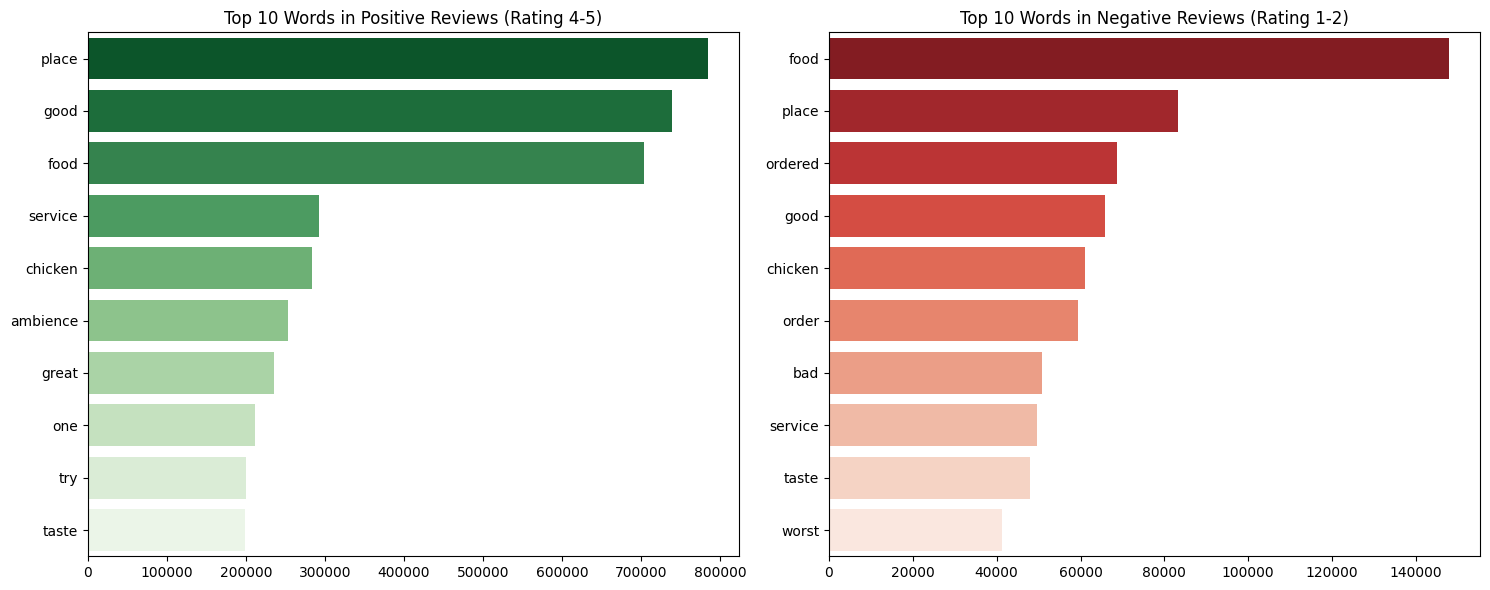

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

words, counts = zip(*top_pos_words)
sns.barplot(x=list(counts), y=list(words), ax=axes[0], palette='Greens_r')
axes[0].set_title('Top 10 Words in Positive Reviews (Rating 4-5)')

words, counts = zip(*top_neg_words)
sns.barplot(x=list(counts), y=list(words), ax=axes[1], palette='Reds_r')
axes[1].set_title('Top 10 Words in Negative Reviews (Rating 1-2)')

plt.tight_layout()
plt.show()

긍정과 부정 리뷰 모두에서 'place', 'food', 'chicken', 'service', 'taste' 등의 단어가 최상위권에 등장한다. 이는 단순 빈도수 방식만으로는 긍/부정의 문맥을 명확히 구분하기 어려운 한계가 발견된다.

In [26]:
final_data = labeled_df[labeled_df['cleaned_text'] != ""].copy()

In [27]:
print(f"\n최종 학습용 데이터 개수: {len(final_data)}")


최종 학습용 데이터 개수: 1117306


앞서 단순 빈도수 방식의 한계를 보완하기 위하여 N-gram과 가중치 부여 방식을 도입하였다.

Unigram(1), Bigram(1, 2), Trigram(1, 3) 비교

In [28]:
ngram_ranges = [(1, 1), (1, 2), (1, 3)]
cv_scores = []
ngram_labels = []

In [29]:
for n_range in ngram_ranges:
    vectorizer_test = TfidfVectorizer(max_features=2000, ngram_range=n_range)
    X_test = vectorizer_test.fit_transform(final_data['cleaned_text'])
    y_test = final_data['label']
    
    scores = cross_val_score(LogisticRegression(max_iter=500), X_test, y_test, cv=3, scoring='accuracy')
    avg_score = scores.mean()
    
    cv_scores.append(avg_score)
    ngram_labels.append(str(n_range))
    print(f"  N-gram {n_range}: 정확도 {avg_score:.4f}")

  N-gram (1, 1): 정확도 0.9518
  N-gram (1, 2): 정확도 0.9506
  N-gram (1, 3): 정확도 0.9507


C:\Users\하정훈\AppData\Local\Temp\ipykernel_43168\626549816.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=ngram_labels, y=cv_scores, palette='viridis')


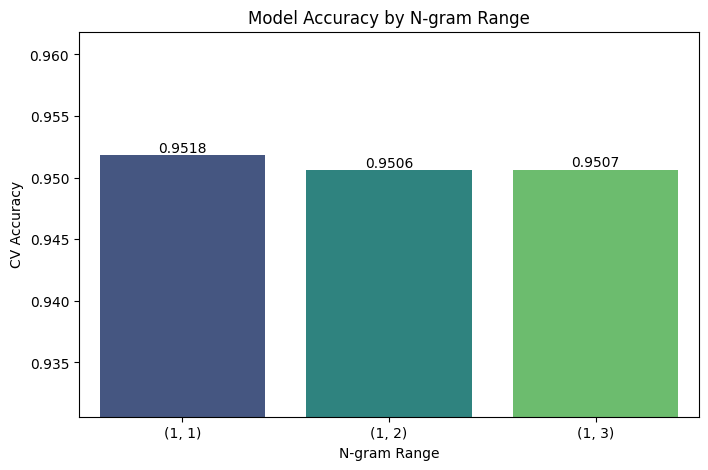

In [30]:
plt.figure(figsize=(8, 5))
sns.barplot(x=ngram_labels, y=cv_scores, palette='viridis')
plt.ylim(min(cv_scores)-0.02, max(cv_scores)+0.01)
plt.title('Model Accuracy by N-gram Range')
plt.ylabel('CV Accuracy')
plt.xlabel('N-gram Range')
for i, v in enumerate(cv_scores):
    plt.text(i, v, f"{v:.4f}", ha='center', va='bottom')
plt.show()

앞서 확인한, 긍정과 부정의 상위권에 공통으로 있는 단어들을 제외하기 위하여 N-gram의 범위를 (1, 3)까지 확장하여 실험하였으나, 예상과 달리 단일 단어인 Unigram(1-gram) 기반의 모델이 95.18%로 가장 높은 성능을 보였다.

불용어를 위에서 제외했음에도 불구하고 위와 같은 결과가 나온 원인을 조사하기 위하여 아래의 코드를 실행한다.

C:\Users\하정훈\AppData\Local\Temp\ipykernel_43168\998190948.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bigram_df, x='Count', y='Bigram', palette='viridis')


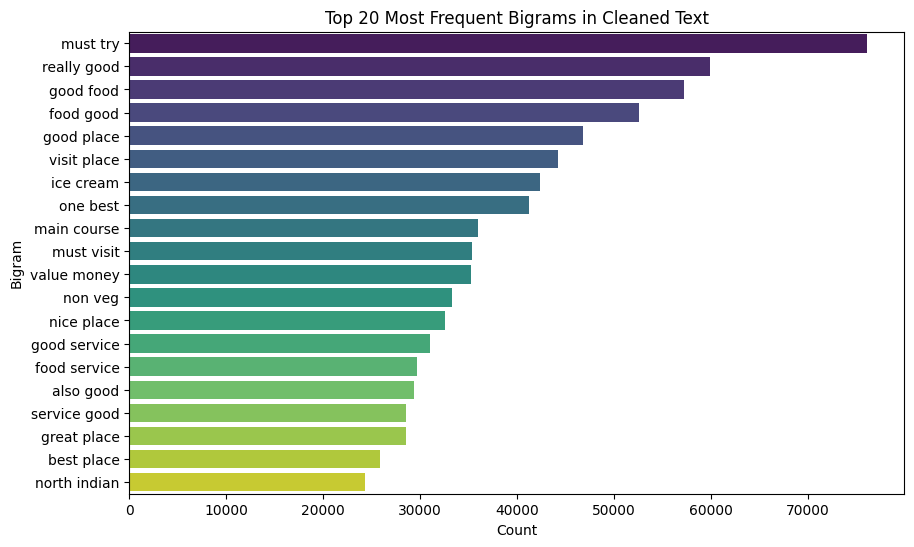


[차원(피처) 크기 비교]
1-gram 사용 시 학습할 어휘 수: 48153개
1,2-gram 사용 시 학습할 어휘 수: 1006164개
-> 1,2-gram 도입 시 모델이 처리해야 할 차원이 약 20.9배 폭증합니다.


In [31]:
# Bigram(2단어 조합) 상위 20개 확인
vec_bigram = CountVectorizer(ngram_range=(2, 2), max_features=20)
X_bigram = vec_bigram.fit_transform(final_data['cleaned_text'])

# 빈도수 집계
sum_bigrams = X_bigram.sum(axis=0)
words_freq = [(word, sum_bigrams[0, idx]) for word, idx in vec_bigram.vocabulary_.items()]
words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)

bigram_df = pd.DataFrame(words_freq, columns=['Bigram', 'Count'])

plt.figure(figsize=(10, 6))
sns.barplot(data=bigram_df, x='Count', y='Bigram', palette='viridis')
plt.title('Top 20 Most Frequent Bigrams in Cleaned Text')
plt.show()

# 차원의 저주 확인 (1-gram vs 1,2-gram 어휘 수 비교)
vec_1gram = CountVectorizer(ngram_range=(1, 1))
vec_1gram.fit(final_data['cleaned_text'])
vocab_1 = len(vec_1gram.vocabulary_)

vec_2gram = CountVectorizer(ngram_range=(1, 2))
vec_2gram.fit(final_data['cleaned_text'])
vocab_2 = len(vec_2gram.vocabulary_)

print(f"\n[차원(피처) 크기 비교]")
print(f"1-gram 사용 시 학습할 어휘 수: {vocab_1}개")
print(f"1,2-gram 사용 시 학습할 어휘 수: {vocab_2}개")
print(f"-> 1,2-gram 도입 시 모델이 처리해야 할 차원이 약 {vocab_2/vocab_1:.1f}배 폭증합니다.")

1. 차원 처리 측면에서의 1-gram의 효율성(max_features=2,000)
- 성능도 근소한 차이지만, 1-gram이 더 높은 수치를 보여주고 있다.
- 또한 1,2-gram 도입 시 모델이 처리해야 할 차원이 약 20배 증가한다.
- 그러나 2,2-gram의 상위권 단어 조합이 매우 유의미함
- 따라서, 1,2-gram 도입 가능성을 심화 분석하기 위하여 아래 상세 분석을 실시함.
2. 1,2-gram에 대한 상세 분석(max_features=2,000)
- 1,2-gram에서 불용어는 완벽히 제거되었음을 알 수 있음
- 1,2-gram의 성능이 낮게 나오는 이유는 1,2-gram의 추가 정보가 1-gram과 겹쳐 단어 하나로도 성능에 기여할 수 있는 것으로 확인됨.
1) good food는 good과 food로 1-gram에서 나뉠 수 있음. good 자체로 '긍정'으로서 매우 유의미함
2) must try는 must try로 1-gram에서 나뉠 수 있음. try 자체로 '긍정'으로서 매우 유의미함.

1,2-gram을 차원 처리 측면에서 효율성이 낮아 채택하지 말아야 하는지 정확한 근거를 찾아보기 위하여 max_features를 1,000부터 9,000까지 2,000 간격으로 확인하였음. max_features가 다른 값을 가질 때 각 1,2-gram의 성능의 우위 관계가 달라질 경우 결론을 재검토할 예정임.

--- Max Features: 1000 ---
  1-gram Only: 0.9447
  1,2-gram Mix: 0.9445
--- Max Features: 3000 ---
  1-gram Only: 0.9542
  1,2-gram Mix: 0.9553
--- Max Features: 5000 ---
  1-gram Only: 0.9581
  1,2-gram Mix: 0.9593
--- Max Features: 7000 ---
  1-gram Only: 0.9596
  1,2-gram Mix: 0.9623
--- Max Features: 9000 ---
  1-gram Only: 0.9605
  1,2-gram Mix: 0.9646


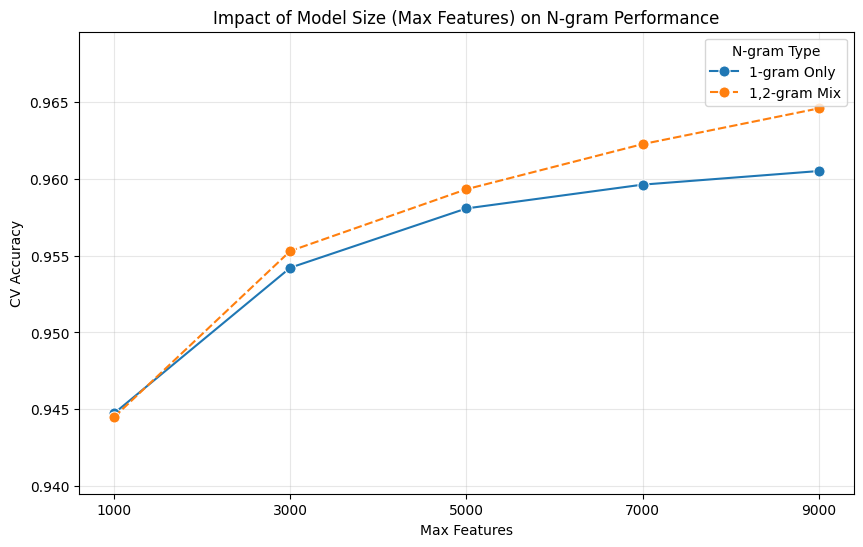


[최종 실험 결론]
최고 성능 설정: Max Features 9000개, 1,2-gram Mix (정확도: 0.9646)


In [32]:
feature_limits = [1000, 3000, 5000, 7000, 9000]
ngram_settings = [
    ("1-gram Only", (1, 1)), 
    ("1,2-gram Mix", (1, 2))
]
results = []

for n_feats in feature_limits:
    print(f"--- Max Features: {n_feats} ---")
    
    for name, n_range in ngram_settings:
        tfidf = TfidfVectorizer(max_features=n_feats, ngram_range=n_range)
        X_temp = tfidf.fit_transform(final_data['cleaned_text'])
        y_temp = final_data['label']

        scores = cross_val_score(LogisticRegression(max_iter=500), X_temp, y_temp, cv=3, scoring='accuracy')
        avg_score = scores.mean()
        
        results.append({
            "Max Features": str(n_feats),
            "N-gram Type": name,
            "Accuracy": avg_score
        })
        print(f"  {name}: {avg_score:.4f}")
        
df_res = pd.DataFrame(results)

plt.figure(figsize=(10, 6))
sns.lineplot(data=df_res, x="Max Features", y="Accuracy", hue="N-gram Type", marker="o", style="N-gram Type", markersize=8)

plt.title('Impact of Model Size (Max Features) on N-gram Performance')
plt.ylabel('CV Accuracy')
plt.ylim(df_res['Accuracy'].min() - 0.005, df_res['Accuracy'].max() + 0.005)
plt.grid(True, alpha=0.3)
plt.show()

best_result = df_res.loc[df_res['Accuracy'].idxmax()]

print("\n[최종 실험 결론]")
print(f"최고 성능 설정: Max Features {best_result['Max Features']}개, {best_result['N-gram Type']} (정확도: {best_result['Accuracy']:.4f})")

9,000개의 최대 피쳐에서도 성능이 향상된 것을 확인하였다. 일단, 9,000개의 피쳐를 선택하는 것이 유의미한지 알아보기 위해 아래 코드를 실행하였다.

In [33]:
full_vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=None)
full_vectorizer.fit(final_data['cleaned_text'])

total_vocab = len(full_vectorizer.vocabulary_)
print(f"전체 발견된 1,2-gram 개수: {total_vocab:,}개")

coverage = (9000 / total_vocab) * 100
print(f"선택한 9,000개는 전체의 상위 {coverage:.2f}% 에 해당합니다.")

전체 발견된 1,2-gram 개수: 1,006,164개
선택한 9,000개는 전체의 상위 0.89% 에 해당합니다.


20,000개에서도 성능 향상이 일어나는지 확인해 보았다.

In [34]:
tfidf_20k = TfidfVectorizer(max_features=20000, ngram_range=(1, 2))
X_20k = tfidf_20k.fit_transform(final_data['cleaned_text'])
y_20k = final_data['label']

score_20k = cross_val_score(LogisticRegression(max_iter=500), X_20k, y_20k, cv=3, scoring='accuracy').mean()
print(f"Max Features 20,000 정확도: {score_20k:.4f}")
print(f"9,000개 대비 향상폭: {score_20k - 0.9646:.4f}") 

Max Features 20,000 정확도: 0.9673
9,000개 대비 향상폭: 0.0027


성능 향상이 미묘하더라도 있으므로, 80,000까지 max_features를 다르게 하여 성능을 측정해보았다. 메모리와 시간복잡도를 함께 고려하였다.

In [35]:
print("=== 전체 단어의 빈도수를 계산하여, 상위 N개가 전체의 몇 %를 커버하는지 확인 ===")
count_vect = CountVectorizer(ngram_range=(1, 2))
X_counts = count_vect.fit_transform(final_data['cleaned_text'])

total_word_occurrences = X_counts.sum()
word_freqs = np.array(X_counts.sum(axis=0)).flatten()
sorted_freqs = np.sort(word_freqs)[::-1]
cumulative_coverage = np.cumsum(sorted_freqs) / total_word_occurrences

print(f"전체 텍스트 내 단어 등장 총 횟수: {total_word_occurrences:,}회")
for cut_off in [0.8, 0.9, 0.95, 0.98]:
    num_feats = np.searchsorted(cumulative_coverage, cut_off) + 1
    print(f" -> 상위 {cut_off*100}%의 대화를 커버하려면 필요한 피처 수: {num_feats:,}개")

=== 전체 단어의 빈도수를 계산하여, 상위 N개가 전체의 몇 %를 커버하는지 확인 ===
전체 텍스트 내 단어 등장 총 횟수: 64,235,599회
 -> 상위 80.0%의 대화를 커버하려면 필요한 피처 수: 79,233개
 -> 상위 90.0%의 대화를 커버하려면 필요한 피처 수: 223,873개
 -> 상위 95.0%의 대화를 커버하려면 필요한 피처 수: 392,309개
 -> 상위 98.0%의 대화를 커버하려면 필요한 피처 수: 595,699개


In [36]:
print("\n=== 'Early Stopping' 전략을 적용한 최적 Max Features 탐색 ===")
candidates = [9000, 15000, 20000, 30000, 50000, 80000] 
threshold = 0.001

best_score = 0
best_feat = 0
prev_score = 0

history = []

for n_feats in candidates:
    print(f"Testing Max Features: {n_feats}...", end=" ")
    
    tfidf = TfidfVectorizer(max_features=n_feats, ngram_range=(1, 2))
    X_temp = tfidf.fit_transform(final_data['cleaned_text'])
    y_temp = final_data['label']
    
    score = cross_val_score(LogisticRegression(max_iter=500), X_temp, y_temp, cv=3).mean()
    
    improvement = score - prev_score
    print(f"Accuracy: {score:.4f} (Improvement: +{improvement:.4f})")
    
    history.append((n_feats, score))

    if prev_score > 0 and improvement < threshold:
        print(f"\n[STOP] 성능 향상폭({improvement:.4f})이 기준치({threshold}) 미만입니다.")
        print(f"-> 경제적 효율성을 위해 직전 단계인 {prev_feat}개 (또는 현재 {n_feats}개)에서 멈추는 것을 권장합니다.")
        best_feat = n_feats 
        best_score = score
        break
        
    prev_score = score
    prev_feat = n_feats
    best_feat = n_feats


=== 'Early Stopping' 전략을 적용한 최적 Max Features 탐색 ===
Testing Max Features: 9000... Accuracy: 0.9646 (Improvement: +0.9646)
Testing Max Features: 15000... Accuracy: 0.9661 (Improvement: +0.0015)
Testing Max Features: 20000... Accuracy: 0.9673 (Improvement: +0.0011)
Testing Max Features: 30000... Accuracy: 0.9700 (Improvement: +0.0028)
Testing Max Features: 50000... Accuracy: 0.9721 (Improvement: +0.0021)
Testing Max Features: 80000... Accuracy: 0.9717 (Improvement: +-0.0004)

[STOP] 성능 향상폭(-0.0004)이 기준치(0.001) 미만입니다.
-> 경제적 효율성을 위해 직전 단계인 50000개 (또는 현재 80000개)에서 멈추는 것을 권장합니다.


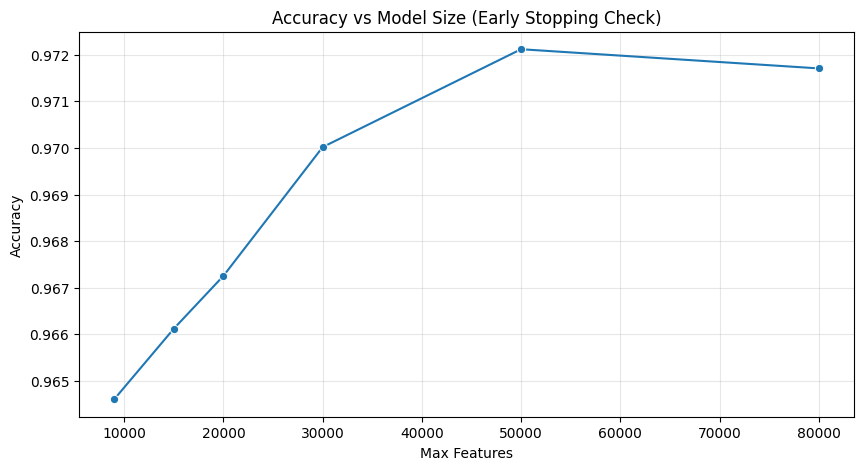

최종 추천 설정: max_features=80000, ngram_range=(1, 2)


In [37]:
hist_df = pd.DataFrame(history, columns=['Max Features', 'Accuracy'])
plt.figure(figsize=(10, 5))
sns.lineplot(data=hist_df, x='Max Features', y='Accuracy', marker='o')
plt.title('Accuracy vs Model Size (Early Stopping Check)')
plt.grid(True, alpha=0.3)
plt.show()

print(f"최종 추천 설정: max_features={best_feat}, ngram_range=(1, 2)")

실행 시간 및 메모리 사용량 확인

In [38]:
candidates = [9000, 15000, 20000, 30000, 50000, 80000] 

print(f"{'Max Features':<15} | {'Accuracy':<10} | {'Time (sec)':<10} | {'Memory (MB)':<10}")
print("-" * 55)

for n_feats in candidates:
    start_time = time.time()

    tfidf = TfidfVectorizer(max_features=n_feats, ngram_range=(1, 2))
    X_temp = tfidf.fit_transform(final_data['cleaned_text'])
    y_temp = final_data['label']

    score = cross_val_score(LogisticRegression(max_iter=500), X_temp, y_temp, cv=3).mean()

    end_time = time.time()
    elapsed_time = end_time - start_time
    
    memory_usage = (X_temp.data.nbytes + X_temp.indices.nbytes + X_temp.indptr.nbytes) / (1024 * 1024)
    
    print(f"{n_feats:<15} | {score:.4f}     | {elapsed_time:.2f}s      | {memory_usage:.1f} MB")

Max Features    | Accuracy   | Time (sec) | Memory (MB)
-------------------------------------------------------
9000            | 0.9646     | 64.92s      | 414.3 MB
15000           | 0.9661     | 67.36s      | 443.0 MB
20000           | 0.9673     | 68.29s      | 459.2 MB
30000           | 0.9700     | 72.34s      | 482.5 MB
50000           | 0.9721     | 73.03s      | 513.0 MB
80000           | 0.9717     | 74.34s      | 542.9 MB


Early Stopping 전략을 적용하여 피처 수를 9,000개부터 80,000개까지 확장하며 성능, 시간, 메모리 효율성을 종합적으로 분석한 결과, 다음과 같은 결론을 얻었다.
1. 정확도는 50,000개(0.9721)에서 정점을 찍고, 80,000개(0.9717)에서는 오히려 하락했다. 이는 과도한 피처가 노이즈로 작용하여 모델의 일반화 성능을 저해함을 증명한다(과적합).
2. 50,000개가 수치적으로 최고였으나, 피처의 수가 66% 증가한 30,000개 대비 성능 향상폭은 0.2%(0.9700->0.9721)에 불과했다. 반면, 메모리 점유율은 약 30MB 증가하고 연산 시간 또한 소폭 상승하여 성능 효율이 저하됨을 확인할 수 있었다.
따라서, 정확도 97% 달성과 과적합 방지 및 연산 효율성을 모두 만족하는 max_features=30000, ngram_range=(1, 2)를 최종 모델의 파라미터로 확정했다.

성능 점수에 과적합 영향은 없다. 아래와 같은 이유에서다.
1. cross_val_score(교차 검증)
- 데이터 3등분 3번 반복 평균 점수
2. 최적의 피처 수 찾기
- Early Stopping
- 차원 축소 규제 역할
3. 로지스틱 회귀 모델
- L2 규제 적용

max_features=30,000, 1,2-gram 적용

In [39]:
best_tfidf = TfidfVectorizer(max_features=30000, ngram_range=(1, 2))
X_best = best_tfidf.fit_transform(final_data['cleaned_text'])
y_best = final_data['label']

In [40]:
log_model_final = LogisticRegression(max_iter=1000)
log_model_final.fit(X_best, y_best)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [41]:
feature_names = best_tfidf.get_feature_names_out()
coefs = log_model_final.coef_[0]
coef_df = pd.DataFrame({'word': feature_names, 'coefficient': coefs})

In [42]:
top_pos = coef_df.sort_values(by='coefficient', ascending=False).head(10)
top_neg = coef_df.sort_values(by='coefficient', ascending=True).head(10)

C:\Users\하정훈\AppData\Local\Temp\ipykernel_43168\1597970872.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_pos, x='coefficient', y='word', ax=axes[0], palette='Greens_r')
C:\Users\하정훈\AppData\Local\Temp\ipykernel_43168\1597970872.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_neg, x='coefficient', y='word', ax=axes[1], palette='Reds_r')


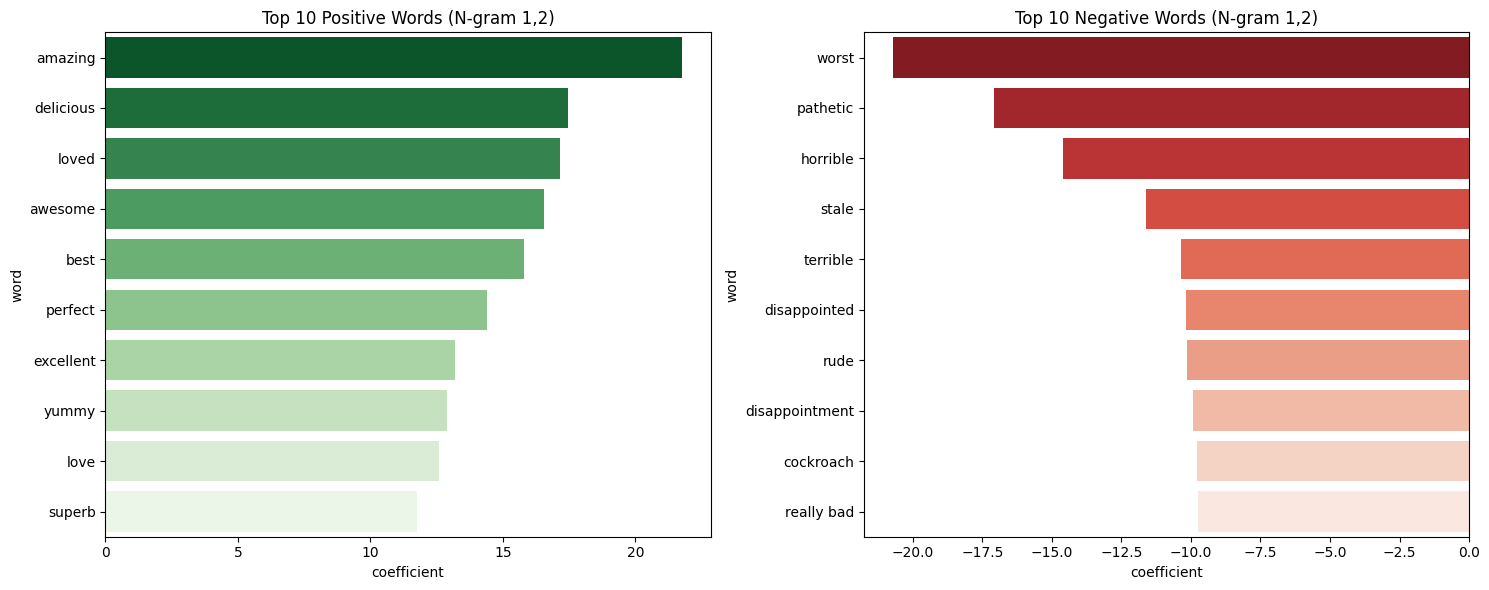

In [43]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
sns.barplot(data=top_pos, x='coefficient', y='word', ax=axes[0], palette='Greens_r')
axes[0].set_title('Top 10 Positive Words (N-gram 1,2)')
sns.barplot(data=top_neg, x='coefficient', y='word', ax=axes[1], palette='Reds_r')
axes[1].set_title('Top 10 Negative Words (N-gram 1,2)')
plt.tight_layout()
plt.show()

데이터 변환
- fit : 어떤 단어들이 있는지 단어장 생성
- transform : 단어장 기준으로 각 리뷰를 숫자로 변환
- y : 맞혀야 하는 정답 레이블

In [44]:
X = best_tfidf.fit_transform(final_data['cleaned_text'])
y = final_data['label']

In [45]:
print("[변환 결과]")
print(f"데이터 행렬 크기 (Shape): {X.shape}")

[변환 결과]
데이터 행렬 크기 (Shape): (1117306, 30000)


In [46]:
print("[추출된 주요 단어 예시]")
print(best_tfidf.get_feature_names_out()[:20])

[추출된 주요 단어 예시]
['aa' 'aalo' 'aalo paratha' 'aaloo' 'aaloo paratha' 'aalu' 'aam'
 'aam panna' 'aaranya' 'ab' 'abc' 'abhijit' 'abhijit saha' 'abhiniblog'
 'abhiniblog wordpress' 'ability' 'able' 'able eat' 'able find'
 'able finish']


벡터 데이터
- Coords (x, y) : x번째 리뷰의 y번째 단어(단어장 기준)
- Values : 중요도

In [47]:
print("첫 번째 리뷰의 벡터 데이터")
print(X[0])

첫 번째 리뷰의 벡터 데이터
<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 38 stored elements and shape (1, 30000)>
  Coords	Values
  (0, 2140)	0.12555429761320472
  (0, 19758)	0.046022955045727204
  (0, 7010)	0.15103238783756093
  (0, 13208)	0.1332369777958475
  (0, 25928)	0.1167024185002621
  (0, 1728)	0.10932194950714874
  (0, 16546)	0.22655238424083105
  (0, 8002)	0.22956485746990063
  (0, 14293)	0.16057792555592768
  (0, 19329)	0.10321188753730584
  (0, 29238)	0.10005002204887607
  (0, 17544)	0.16713256570180843
  (0, 4765)	0.18385121027321624
  (0, 14527)	0.14831476074596156
  (0, 13287)	0.10566781494744876
  (0, 1513)	0.12300511054740171
  (0, 26040)	0.07131423413184777
  (0, 23577)	0.06227739123132259
  (0, 5275)	0.21441557623353744
  (0, 5233)	0.16703888049955096
  (0, 3111)	0.1256034861192746
  (0, 5538)	0.11261643719397049
  (0, 2504)	0.10674084939596519
  (0, 29668)	0.08799558950772833
  (0, 25737)	0.14206889998542285
  (0, 14307)	0.08112246453350129
  (0, 5109)	0.108136

학습용/테스트용 데이터 분리

In [48]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"학습용 데이터 개수: {X_train.shape[0]}")
print(f"테스트용 데이터 개수: {X_test.shape[0]}")

학습용 데이터 개수: 893844
테스트용 데이터 개수: 223462


로지스틱 회귀로 예측

In [49]:
model = LogisticRegression()
model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [50]:
y_pred = model.predict(X_test)

In [51]:
accuracy = accuracy_score(y_test, y_pred)
print(f"[모델 정확도]\n{accuracy:.4f} ({accuracy*100:.2f}%)")

print("[상세 성적표]")
print(classification_report(y_test, y_pred))

print("[오차 행렬 (Confusion Matrix)]")
print(confusion_matrix(y_test, y_pred))

[모델 정확도]
0.9790 (97.90%)
[상세 성적표]
              precision    recall  f1-score   support

           0       0.96      0.93      0.95     45973
           1       0.98      0.99      0.99    177489

    accuracy                           0.98    223462
   macro avg       0.97      0.96      0.97    223462
weighted avg       0.98      0.98      0.98    223462

[오차 행렬 (Confusion Matrix)]
[[ 42974   2999]
 [  1699 175790]]


테스트

In [52]:
test_reviews = [
    "The food was amazing and the service was great!", # 긍정 예상
    "Absolutely terrible. The food was cold and staff was rude.", # 부정 예상
    "It was okay, not bad but not good either." # 애매함
]
clean_tests = [preprocess_text(text) for text in test_reviews]

X_new = best_tfidf.transform(clean_tests)

In [53]:
predictions = model.predict(X_new)
probs = model.predict_proba(X_new)

In [54]:
print("[실전 테스트 결과]")
for text, pred, prob in zip(test_reviews, predictions, probs):
    sentiment = "긍정(1)" if pred == 1 else "부정(0)"
    print(f"리뷰: {text}")
    print(f"예측: {sentiment} (확률: {prob[pred]:.2f})")
    print("-" * 30)

[실전 테스트 결과]
리뷰: The food was amazing and the service was great!
예측: 긍정(1) (확률: 1.00)
------------------------------
리뷰: Absolutely terrible. The food was cold and staff was rude.
예측: 부정(0) (확률: 1.00)
------------------------------
리뷰: It was okay, not bad but not good either.
예측: 부정(0) (확률: 0.99)
------------------------------


전체 데이터 대상 만족도 분석

In [55]:
full_X = best_tfidf.transform(final_data['cleaned_text'])

긍정 확률 평균 확인

아래 코드는 학습된 모델로 전체 데이터를 다시 예측하는데, 학습 데이터셋에 대해서는 레이블 값을 그대로 예측할 가능성이 크므로, cross_val_predict를 사용

In [56]:
clean_model = LogisticRegression(max_iter=1000)
y_probs = cross_val_predict(clean_model, full_X, y, cv=5, method='predict_proba')

final_data['ai_prob'] = y_probs[:, 1]

- 식당별로 리뷰 개수의 평균, 평균 별점, 모델이 예측한 긍정 확률의 평균을 구함
- 리뷰가 너무 적은 식당은 제외하였음(리뷰가 10개 미만인 식당 제외)

In [57]:
restaurant_group = final_data.groupby('name').agg({
    'rating': 'mean',          
    'ai_prob': 'mean',         
    'review_text': 'count'     
}).rename(columns={'review_text': 'review_count'})

target_restaurants = restaurant_group[restaurant_group['review_count'] >= 10].copy()

AI가 예측한 확률(0~1)을 실제 별점과 비교하기 위하여 5점 만점으로 환산

In [58]:
target_restaurants['ai_score_5'] = 1 + target_restaurants['ai_prob'] * 4

거품 지수(Gap) 계산
- (기존 별점 - AI 확률)이 클수록 별점은 높은데 텍스트는 부정적이다 -> 거품
- (기존 별점 - AI 확률)이 작을수록(음수) 별점은 낮은데 텍스트는 긍정적이다

In [59]:
target_restaurants['gap'] = target_restaurants['rating'] - target_restaurants['ai_score_5']

결과 정렬(거품이 심한 순서대로)

In [60]:
sorted_df = target_restaurants.sort_values(by='gap', ascending=False)

In [61]:
print("[분석 결과(상위 5개 : 별점>텍스트(AI 확률 기반))]")
print(sorted_df[['rating', 'ai_score_5', 'gap', 'review_count']].head(5))

print("[분석 결과(하위 5개 : 별점<텍스트(AI 확률 기반))]")
print(sorted_df[['rating', 'ai_score_5', 'gap', 'review_count']].tail(5))

[분석 결과(상위 5개 : 별점>텍스트(AI 확률 기반))]
                     rating  ai_score_5       gap  review_count
name                                                           
Tanu Di's Kitchen       5.0    3.020717  1.979283            10
Spice It                4.5    3.283411  1.216589            20
AM Biryani Junction     4.0    2.991191  1.008809            10
Royal Tea House         2.0    1.000390  0.999610            12
Chettayees              2.0    1.075844  0.924156            12
[분석 결과(하위 5개 : 별점<텍스트(AI 확률 기반))]
                        rating  ai_score_5       gap  review_count
name                                                              
North Indian Tadka    3.250000    4.841370 -1.591370            20
Navaneetha            3.166667    4.861323 -1.694656            18
Samosa Express        2.642857    4.411120 -1.768263            14
Sri Krishna Darshini  2.833333    4.750970 -1.917636            18
Food Magic            2.750000    4.716787 -1.966787            12


3점대 제거 시각화

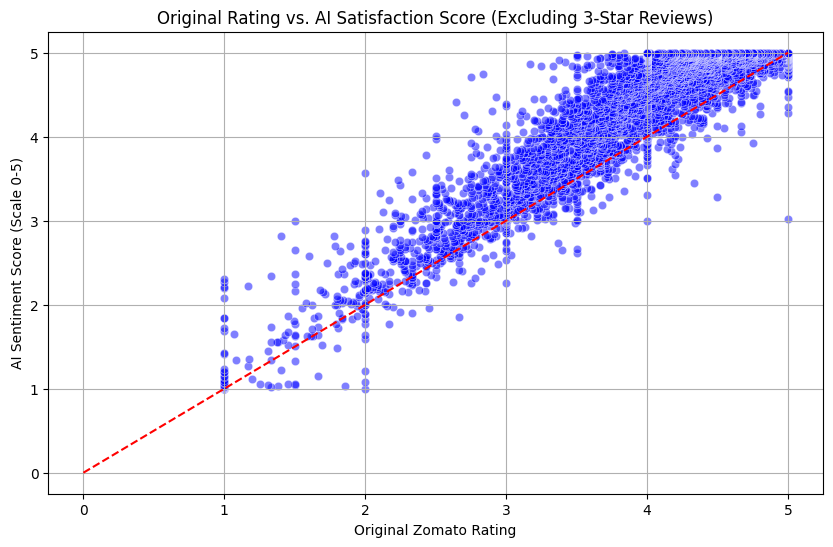

In [62]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=sorted_df, x='rating', y='ai_score_5', alpha=0.5, color='blue')
plt.plot([0, 5], [0, 5], color='red', linestyle='--')

plt.title('Original Rating vs. AI Satisfaction Score (Excluding 3-Star Reviews)')
plt.xlabel('Original Zomato Rating')
plt.ylabel('AI Sentiment Score (Scale 0-5)')
plt.grid(True)
plt.show()

위 그래프(3점 제거)는 명백한 호불호를 바탕으로(긍정 1, 부정 0) 식당의 평균 만족도 지수를 역추적할 수 있음을 시사한다.

고전적인 방법의 TF-IDF와 같은 방식보다 BERT와 같은 딥러닝 임베딩을 특징 추출기를 사용하고 머신러닝 분류기에 결합한 하이브리드 모델이 텍스트 감성 분류에서 더 높은 성능을 보일 것이다.

로지스틱 회귀, 랜덤 포레스트, XGBoost 3가지 모델 도입

In [63]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42),
    "XGBoost": XGBClassifier(eval_metric='logloss', n_jobs=-1, random_state=42)
}
results = []

In [64]:
for name, model in models.items():
    print(f"Running {name}...")
    
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    acc = accuracy_score(y_test, pred)
    
    results.append({
        "Model": name,
        "Accuracy": acc,
        "F1-Score": classification_report(y_test, pred, output_dict=True)['weighted avg']['f1-score']
    })

Running Logistic Regression...
Running Random Forest...
Running XGBoost...


In [65]:
results_df = pd.DataFrame(results).sort_values(by='Accuracy', ascending=False)

print("[모델 성능 비교 결과]")
print(results_df)

[모델 성능 비교 결과]
                 Model  Accuracy  F1-Score
1        Random Forest  0.993516  0.993496
0  Logistic Regression  0.978976  0.978864
2              XGBoost  0.963815  0.963602


In [66]:
sample_df = final_data.sample(n=2000, random_state=42).copy()
sample_y = sample_df['label']

In [67]:
tfidf_vect = TfidfVectorizer(max_features=1000)
X_tfidf = tfidf_vect.fit_transform(sample_df['cleaned_text'])

---

[TF-IDF VS BERT 성능 비교]

고전적인 방법의 TF-IDF와 같은 방식보다 BERT와 같은 딥러닝 임베딩을 특징 추출기를 사용하고 머신러닝 분류기에 결합한 하이브리드 모델이 텍스트 감성 분류에서 더 높은 성능을 보일 것이다.

BERT 임베딩 벡터화

In [68]:
bert_model = SentenceTransformer('all-MiniLM-L6-v2')
X_bert = bert_model.encode(sample_df['cleaned_text'].tolist())

성능 비교 함수

In [69]:
def evaluate_embedding(X, y, method_name):
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_tr, y_tr)
    
    score = clf.score(X_te, y_te)
    print(f"[{method_name}] 정확도: {score:.4f}")
    return score

In [70]:
print("가설 검증 결과(TF-IDF vs BERT)")
score_tfidf = evaluate_embedding(X_tfidf, sample_y, "TF-IDF (Baseline)")
score_bert = evaluate_embedding(X_bert, sample_y, "BERT (Deep Learning)")

if score_bert > score_tfidf:
    print(f"결과: BERT 임베딩이 TF-IDF보다 {score_bert - score_tfidf:.4f}만큼 성능이 좋습니다.")
else:
    print("\n결과: 데이터가 적거나 리뷰가 단순하여 TF-IDF와 큰 차이가 없거나 낮습니다.")

가설 검증 결과(TF-IDF vs BERT)
[TF-IDF (Baseline)] 정확도: 0.8900
[BERT (Deep Learning)] 정확도: 0.9350
결과: BERT 임베딩이 TF-IDF보다 0.0450만큼 성능이 좋습니다.


---

### 3점 리뷰 포함하여 수행
- 3점 리뷰는 텍스트의 긍/부정 맥락과 다르게 '중간'을 부여하는 모호한 평점이다.
- 기존에 3점대 리뷰를 제외한 데이터를 기반으로 학습한 모델을 이용하였다. 1~2점(부정), 4~5점(긍정) 데이터에도 노이즈 데이터가 포함되어 있을 수 있으나 비교적 확실한 데이터를 기반으로 명확한 감성 기준을 확립할 수 있다.
- 이러한 모델로 '중간 입장'인 3점 리뷰의 긍/부정을 확률 기반으로 예측하여 재평가할 수 있다.
- 데이터의 손실 없이 지표에 반영하여 만족도 지수의 밀도와 정밀도를 향상시켰다.

3점(-1) 데이터 추출

In [71]:
ambiguous_df = zomato_df[zomato_df['label'] == -1].copy()

In [72]:
print(f"3점 데이터 {len(ambiguous_df)}개 전처리")
ambiguous_df['cleaned_text'] = ambiguous_df['review_text'].apply(preprocess_text)
ambiguous_df = ambiguous_df[ambiguous_df['cleaned_text'] != ""]

3점 데이터 198536개 전처리


벡터화
- 학습에 사용한 vectorizer 그대로 사용함

In [73]:
X_ambiguous = best_tfidf.transform(ambiguous_df['cleaned_text'])

성능이 가장 좋은 Random Forest 사용

In [74]:
target_model = models['Random Forest']
ambiguous_df['ai_prob'] = target_model.predict_proba(X_ambiguous)[:, 1]

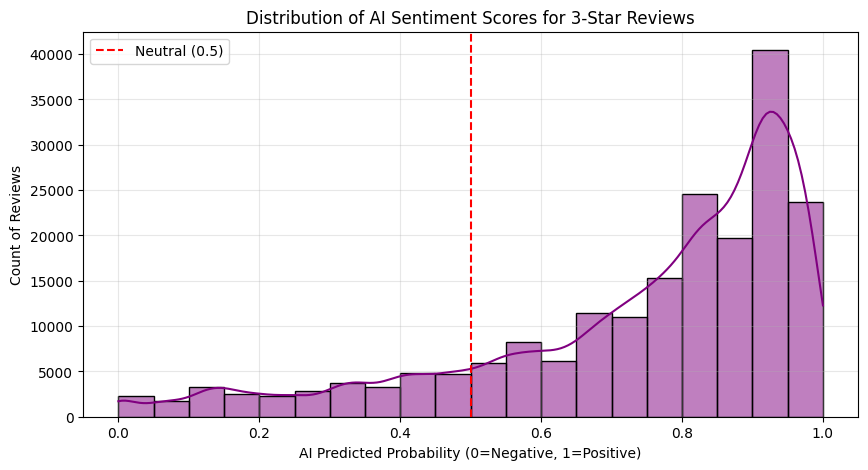

전체 3점 리뷰 개수: 198152
애매한(0.4~0.6) 리뷰 개수: 21835 (11.0%)
확실한 긍/부정 경향을 보인 리뷰: 176317 (89.0%)


In [75]:
plt.figure(figsize=(10, 5))

sns.histplot(ambiguous_df['ai_prob'], bins=20, kde=True, color='purple')

plt.title('Distribution of AI Sentiment Scores for 3-Star Reviews')
plt.xlabel('AI Predicted Probability (0=Negative, 1=Positive)')
plt.ylabel('Count of Reviews')
plt.axvline(x=0.5, color='red', linestyle='--', label='Neutral (0.5)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

neutral_count = len(ambiguous_df[(ambiguous_df['ai_prob'] > 0.4) & (ambiguous_df['ai_prob'] < 0.6)])
biased_count = len(ambiguous_df) - neutral_count
print(f"전체 3점 리뷰 개수: {len(ambiguous_df)}")
print(f"애매한(0.4~0.6) 리뷰 개수: {neutral_count} ({neutral_count/len(ambiguous_df)*100:.1f}%)")
print(f"확실한 긍/부정 경향을 보인 리뷰: {biased_count} ({biased_count/len(ambiguous_df)*100:.1f}%)")

In [76]:
final_full_data = pd.concat([final_data, ambiguous_df[['name', 'rating', 'review_text', 'cleaned_text', 'ai_prob']]])

print(f"전체 분석 대상 리뷰 개수: {len(final_full_data)}")

전체 분석 대상 리뷰 개수: 1315458


3점대 포함 최종 만족도 지수 재산출 및 시각화

In [77]:
restaurant_final = final_full_data.groupby('name').agg({
    'rating': 'mean',       
    'ai_prob': 'mean',   
    'review_text': 'count' 
}).rename(columns={'review_text': 'review_count'})

target_final = restaurant_final[restaurant_final['review_count'] >= 10].copy()

target_final['ai_score_5'] = 1 + target_final['ai_prob'] * 4
target_final['gap'] = target_final['rating'] - target_final['ai_score_5']

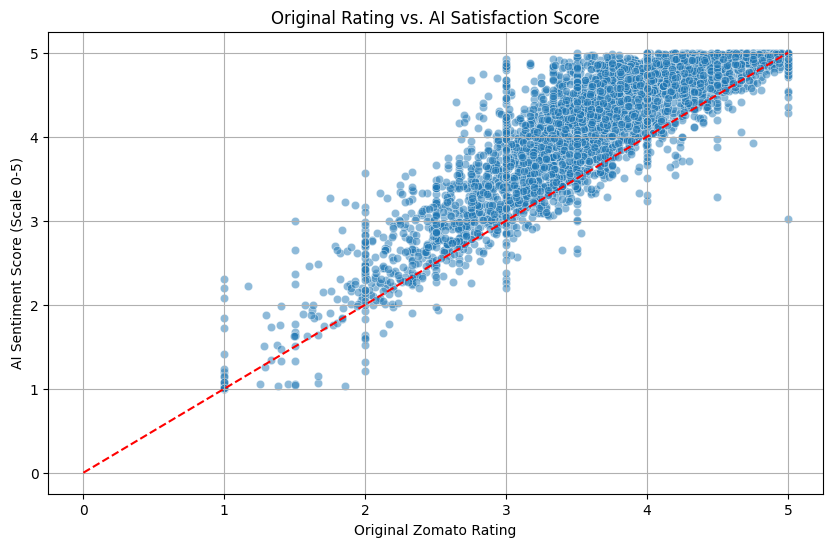

해석: 붉은 점선 아래에 있는 식당들은 '별점 거품'이 있는 곳(별점 > AI점수)이고,
붉은 점선 위에 있는 식당들은 '숨겨진 맛집'(별점 < AI점수)입니다.


In [78]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=target_final, x='rating', y='ai_score_5', alpha=0.5)

plt.plot([0, 5], [0, 5], color='red', linestyle='--')

plt.title('Original Rating vs. AI Satisfaction Score')
plt.xlabel('Original Zomato Rating')
plt.ylabel('AI Sentiment Score (Scale 0-5)')
plt.grid(True)
plt.show()

print("해석: 붉은 점선 아래에 있는 식당들은 '별점 거품'이 있는 곳(별점 > AI점수)이고,")
print("붉은 점선 위에 있는 식당들은 '숨겨진 맛집'(별점 < AI점수)입니다.")

### 결론
기존의 평점 데이터는 해당 식당의 평균 평점을 제공한다. 이는 노이즈 데이터(긍정 텍스트이지만 1~2점, 부정 텍스트이지만 4~5점)와 모호한 데이터(3점)가 혼합되어 식당의 객관적인 만족도 지수를 보여주지 못한다. 3점대 제거 데이터로 노이즈 데이터가 포함되어 있지만, 대규모의 데이터에서 정상적인 패턴은 리뷰 텍스트와 평점 간에 강한 상관관계를 가진다는 점을 가정하여, 각 개별 리뷰의 긍/부정을 확률(0과 1 사이의 값) 기반으로 예측값을 도출한다. 이러한 명확한 감성 기준이 확립된 모델로 3점 리뷰를 포함하여 모든 점수대의 리뷰를 재평가함으로써 실제 만족도에 가까운 지수를 산출할 수 있다.

---

### 다른 데이터로 적용

#### Yelp Restaurant Reviews
- kaggle url : https://www.kaggle.com/datasets/farukalam/yelp-restaurant-reviews

In [79]:
yelp_path = kagglehub.dataset_download("farukalam/yelp-restaurant-reviews")

print("Path to dataset files:", yelp_path)

Path to dataset files: C:\Users\하정훈\.cache\kagglehub\datasets\farukalam\yelp-restaurant-reviews\versions\1


In [80]:
try:
  file_list = os.listdir(yelp_path)
  print(file_list)
except FileNotFoundError:
  print(f"오류: '{yelp_path}' 경로를 찾을 수 없습니다.")

['Yelp Restaurant Reviews.csv']


In [81]:
yelp_data = pd.read_csv(f'{yelp_path}\\Yelp Restaurant Reviews.csv')
yelp_copy = yelp_data.copy()
yelp_copy.head()

,Yelp URL,Rating,Date,Review Text
0,https://www.yelp.com/biz/sidney-dairy-barn-sidney,5,1/22/2022,All I can say is they have very good ice cream...
1,https://www.yelp.com/biz/sidney-dairy-barn-sidney,4,6/26/2022,Nice little local place for ice cream.My favor...
2,https://www.yelp.com/biz/sidney-dairy-barn-sidney,5,8/7/2021,A delicious treat on a hot day! Staff was very...
3,https://www.yelp.com/biz/sidney-dairy-barn-sidney,4,7/28/2016,This was great service and a fun crew! I got t...
4,https://www.yelp.com/biz/sidney-dairy-barn-sidney,5,6/23/2015,This is one of my favorite places to get ice c...


In [82]:
len(set(yelp_copy['Yelp URL']))

49

Yelp Restuarnat Reviews 데이터셋은 실질적으로 49개의 식당 데이터만 있다.

'Yelp URL' 칼럼 확인 결과, 중복을 제외한 실제 URL의 개수(식당의 수)는 49개로, 모델의 일반화 성능을 확인하기에는 부족하다고 판단하였다. 따라서, 4GB로 매우 크지만 아래 데이터셋(Yelp Dataset)을 활용하여 일반화 성능을 확인하였다.

#### Yelp Dataset

In [83]:
yelp_path = kagglehub.dataset_download("yelp-dataset/yelp-dataset")
print("파일 경로:", yelp_path)

file_list = os.listdir(yelp_path)
print("폴더 내 파일:", file_list)

파일 경로: C:\Users\하정훈\.cache\kagglehub\datasets\yelp-dataset\yelp-dataset\versions\4
폴더 내 파일: ['Dataset_User_Agreement.pdf', 'yelp_academic_dataset_business.json', 'yelp_academic_dataset_checkin.json', 'yelp_academic_dataset_review.json', 'yelp_academic_dataset_tip.json', 'yelp_academic_dataset_user.json']


In [84]:
business_file = os.path.join(yelp_path, "yelp_academic_dataset_business.json")
review_file = os.path.join(yelp_path, "yelp_academic_dataset_review.json")

In [85]:
print('데이터 중 식당 데이터만 추출\n')
restaurant_ids = set()

with open(business_file, 'r', encoding='utf-8') as f:
    for line in f:
        try:
            biz = json.loads(line)
            # 카테고리가 존재하고, 'Restaurants'나 'Food'가 포함된 경우만 추출
            if biz['categories'] and ('Restaurants' in biz['categories'] or 'Food' in biz['categories']):
                restaurant_ids.add(biz['business_id'])
        except ValueError:
            continue

print(f"-> 추출된 식당(Restaurant/Food) 개수: {len(restaurant_ids):,}개")

데이터 중 식당 데이터만 추출

-> 추출된 식당(Restaurant/Food) 개수: 64,616개


In [86]:
print("[리뷰 데이터 로드 및 필터링(200,000개)]")

chunks = []
target_count = 200000
current_count = 0

json_reader = pd.read_json(review_file, lines=True, chunksize=10000)

for chunk in json_reader:
    filtered_chunk = chunk[chunk['business_id'].isin(restaurant_ids)]
    
    filtered_chunk = filtered_chunk[['business_id', 'stars', 'text']]
    
    chunks.append(filtered_chunk)
    current_count += len(filtered_chunk)
    
    if len(chunks) % 5 == 0:
        print(f"  -> 현재 {current_count}개 수집됨")

    if current_count >= target_count:
        print(f"-> 목표 수량 달성 ({current_count}개)")
        break

yelp_copy = pd.concat(chunks).head(target_count).copy()
yelp_copy.rename(columns={'stars': 'rating', 'text': 'review_text'}, inplace=True)

print(f"\n-> 최종 분석용 데이터 개수: {len(yelp_copy)}개")

[리뷰 데이터 로드 및 필터링(200,000개)]
  -> 현재 39250개 수집됨
  -> 현재 78428개 수집됨
  -> 현재 117761개 수집됨
  -> 현재 157028개 수집됨
  -> 현재 196004개 수집됨
-> 목표 수량 달성 (203787개)

-> 최종 분석용 데이터 개수: 200000개


In [87]:
yelp_copy.head()

,business_id,rating,review_text
0,XQfwVwDr-v0ZS3_CbbE5Xw,3,"If you decide to eat here, just be aware it is..."
2,YjUWPpI6HXG530lwP-fb2A,3,Family diner. Had the buffet. Eclectic assortm...
3,kxX2SOes4o-D3ZQBkiMRfA,5,"Wow! Yummy, different, delicious. Our favo..."
4,e4Vwtrqf-wpJfwesgvdgxQ,4,Cute interior and owner (?) gave us tour of up...
5,04UD14gamNjLY0IDYVhHJg,1,I am a long term frequent customer of this est...


In [88]:
yelp_copy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 200000 entries, 0 to 255087
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   business_id  200000 non-null  object
 1   rating       200000 non-null  int64 
 2   review_text  200000 non-null  object
dtypes: int64(1), object(2)
memory usage: 6.1+ MB


In [89]:
print("[텍스트 전처리 및 AI 만족도 예측]")

yelp_copy['cleaned_text'] = yelp_copy['review_text'].apply(preprocess_text)
yelp_copy = yelp_copy[yelp_copy['cleaned_text'] != ""]

X_yelp = best_tfidf.transform(yelp_copy['cleaned_text'])

yelp_probs = log_model_final.predict_proba(X_yelp)[:, 1]

yelp_copy['ai_score'] = 1 + (yelp_probs * 4)

print(f"-> 전처리 및 예측 완료. (데이터 크기: {len(yelp_copy)}개)")

[텍스트 전처리 및 AI 만족도 예측]
-> 전처리 및 예측 완료. (데이터 크기: 199994개)


In [90]:
print("[식당별 평균 점수 산출]")

yelp_grouped = yelp_copy.groupby('business_id').agg({
    'rating': 'mean',       
    'ai_score': 'mean',      
    'review_text': 'count'  
}).rename(columns={'review_text': 'review_count'})

yelp_final = yelp_grouped[yelp_grouped['review_count'] >= 10].copy()

print(f"-> 최종 분석 대상 식당 수: {len(yelp_final)}개 (리뷰 10개 이상)")

[식당별 평균 점수 산출]
-> 최종 분석 대상 식당 수: 3105개 (리뷰 10개 이상)


[시각화]


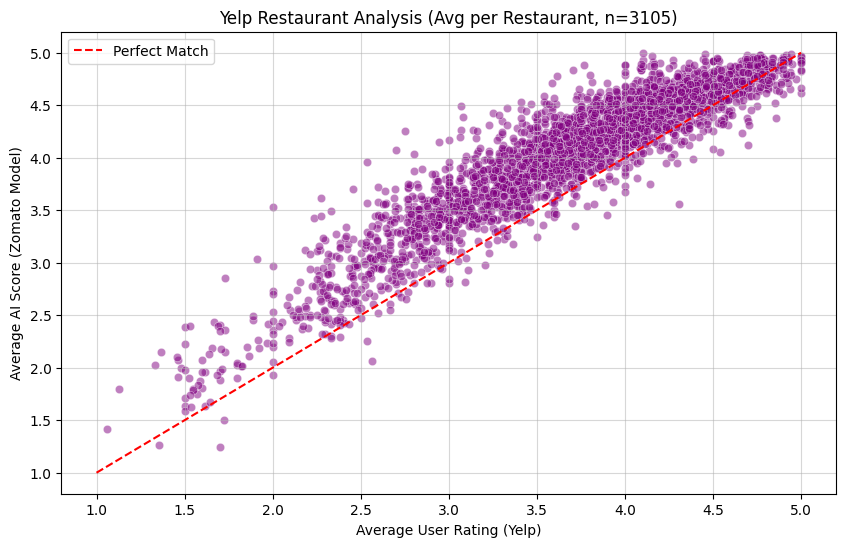

In [91]:
print("[시각화]")

plt.figure(figsize=(10, 6))

sns.scatterplot(data=yelp_final, x='rating', y='ai_score', alpha=0.5, color='purple')

plt.plot([1, 5], [1, 5], color='red', linestyle='--', label='Perfect Match')

plt.title(f'Yelp Restaurant Analysis (Avg per Restaurant, n={len(yelp_final)})')
plt.xlabel('Average User Rating (Yelp)')
plt.ylabel('Average AI Score (Zomato Model)')
plt.legend()
plt.grid(True, alpha=0.5)
plt.xlim(0.8, 5.2)
plt.ylim(0.8, 5.2)
plt.show()

In [92]:
corr = yelp_final['rating'].corr(yelp_final['ai_score'])
print(f"[검증 결과] 식당별 평균 별점과 AI 점수의 상관계수 = {corr:.4f}")

[검증 결과] 식당별 평균 별점과 AI 점수의 상관계수 = 0.9264


상관계수가 0.9264로, 모델의 일반화 성능이 매우 뛰어나다.
- 대규모의 데이터 대상으로 정상의 데이터라면, 리뷰 텍스트와 별점의 평균은 강한 상관관계를 가진다는 것을 가정한 바 있다. 이는 일반적으로 추론이 가능한 사실이지만, 학습된 모델로 이러한 경향성을 도출할 수 있는 건 유의미하다.
- Zomato 데이터로 학습한 모델을 Yelp 데이터로 예측헀을 때 위와 같은 상관계수를 보이는 것은 범용성 측면에서 유의미하다.
- 상관계수 1과 이 모델의 상관계수 0.9264 사이의 약 0.7의 값은 노이즈 데이터의 예측치라고 해석할 수 있다. 이는 해당 모델의 만족도 지수가 필요함을 역설적으로 보여준다.

---

### 일본어 리뷰로 확장
- 기존 제안서에서는 Tokyo Restaurant Reviews on Tabelog 등 일본어 리뷰들이 충분히 확보되어 있을 줄 알았으나, 별점 수치만 있고 텍스트 리뷰가 있는 데이터는 없는 것으로 파악되었다. 
- Yelp Dataset을 활용하여 일본어 텍스트 리뷰를 가진 데이터만 필터링하는 전략으로 수정하였다.
- 기존 전처리 코드에는 영어로만 한정이 되어 일본어 리뷰를 예측할 수 없다. Yelp Dataset에서 일본어 리뷰만 필터링하여 다시 기존 코드를 수행해야 한다.

일본어 감지 함수
- 히라가나, 가타카나, 한자를 감지한다.

In [93]:
def contains_japanese(text):
    if not isinstance(text, str):
        return False
    # 히라가나(3040-309F), 가타카나(30A0-30FF), 한자(4E00-9FFF)
    jp_pattern = re.compile(r'[\u3040-\u309F\u30A0-\u30FF\u4E00-\u9FFF]')
    return bool(jp_pattern.search(text))

일본어 리뷰 분류

In [94]:
jp_reviews = []
current_count = 0

review_file = os.path.join(yelp_path, "yelp_academic_dataset_review.json")

json_reader = pd.read_json(review_file, lines=True, chunksize=10000)

for i, chunk in enumerate(json_reader):
    mask = chunk['text'].apply(contains_japanese)
    jp_chunk = chunk[mask].copy()
    
    if not jp_chunk.empty:
        jp_chunk = jp_chunk[['business_id', 'stars', 'text']]
        jp_reviews.append(jp_chunk)
        current_count += len(jp_chunk)
        
    if i % 100 == 0:
        print(f" -> {i*10000:,}개 검사 완료... 현재 일본어 리뷰 {current_count}개 발견")

 -> 0개 검사 완료... 현재 일본어 리뷰 3개 발견
 -> 1,000,000개 검사 완료... 현재 일본어 리뷰 187개 발견
 -> 2,000,000개 검사 완료... 현재 일본어 리뷰 386개 발견
 -> 3,000,000개 검사 완료... 현재 일본어 리뷰 592개 발견
 -> 4,000,000개 검사 완료... 현재 일본어 리뷰 773개 발견
 -> 5,000,000개 검사 완료... 현재 일본어 리뷰 953개 발견
 -> 6,000,000개 검사 완료... 현재 일본어 리뷰 1151개 발견


In [95]:
if jp_reviews:
    final_jp_df = pd.concat(jp_reviews)
    print(f"\n[최종 완료] 총 {len(final_jp_df)}개의 일본어 리뷰를 확보했습니다.")
    
    final_jp_df.to_csv("yelp_japanese_reviews.csv", index=False)
    print("파일 저장 완료: yelp_japanese_reviews.csv")
    
    display(final_jp_df.head())
else:
    print("\n[실패] 일본어 리뷰를 찾지 못했습니다.")


[최종 완료] 총 1342개의 일본어 리뷰를 확보했습니다.
파일 저장 완료: yelp_japanese_reviews.csv


,business_id,stars,text
566,mcr1lAEdvGLMJhuPwI3I2A,5,In Reno for the night. Was a bit skeptical bec...
1906,QUnvoceeKLK201dOflQThA,4,City Parkの近くにある激安かき氷屋さん。シェーブドアイスっていったほうがいいね！\n...
9237,A9rVxmIBtHZRvNhbBaGAWg,2,点了四个菜 没一个好吃的 不适合中国人吃\n\n口水鸡鸡肉不新鲜\n毛血旺的大肠好油\n酸豆...
11851,M1BkW7JZZBrCfT4_Sr4NEQ,4,This was delicious. I ordered a sushi burrito ...
13629,3BJxm-HnvzdwD1zjmSbmyQ,5,After ordering here 7 times I can confirm. Gol...


리뷰에 일본어가 1개라도 포함될 경우 일본어 리뷰로 분류된다. 따라서 일본어가 일정 비중 이상 차지하는 리뷰만 분류하도록 하였다. 앞서 저장한 yelp_japanese_reviews.csv를 활용하였다.

In [96]:
df = pd.read_csv("yelp_japanese_reviews.csv")
print(f"정제 전 데이터 개수: {len(df)}개")

정제 전 데이터 개수: 1342개


일본어 비중 계산 함수

In [97]:
def is_dominant_japanese(text):
    if not isinstance(text, str):
        return False
    
    text_clean = re.sub(r'\s+', '', text)
    if len(text_clean) == 0:
        return False
        
    jp_chars = re.findall(r'[\u3040-\u309F\u30A0-\u30FF\u4E00-\u9FFF]', text)

    ratio = len(jp_chars) / len(text_clean)
    return ratio > 0.15

In [98]:
df['is_jp_dominant'] = df['text'].apply(is_dominant_japanese)

df_clean = df[df['is_jp_dominant']].copy()
df_removed = df[~df['is_jp_dominant']].copy()

In [99]:
print(f"-> 삭제된 리뷰(영어/혼합 등): {len(df_removed)}개")
print(f"-> 남은 리뷰: {len(df_clean)}개")

if not df_removed.empty:
    print("\n[삭제된 리뷰 예시]")
    for text in df_removed['text'].head(3):
        print(f"- {text[:60]}...")

df_clean[['business_id', 'stars', 'text']].to_csv("yelp_japanese_reviews_clean.csv", index=False)
print("\n-> 정제된 파일 저장 완료: yelp_japanese_reviews_clean.csv")

-> 삭제된 리뷰(영어/혼합 등): 750개
-> 남은 리뷰: 592개

[삭제된 리뷰 예시]
- In Reno for the night. Was a bit skeptical because well..it'...
- This was delicious. I ordered a sushi burrito with crab mix ...
- After ordering here 7 times I can confirm. Golden Chopsticks...

-> 정제된 파일 저장 완료: yelp_japanese_reviews_clean.csv


In [100]:
df = pd.read_csv("yelp_japanese_reviews_clean.csv")
print(f"현재 데이터 개수: {len(df)}개")
display(df.head())

현재 데이터 개수: 592개


,business_id,stars,text
0,QUnvoceeKLK201dOflQThA,4,City Parkの近くにある激安かき氷屋さん。シェーブドアイスっていったほうがいいね！\n...
1,A9rVxmIBtHZRvNhbBaGAWg,2,点了四个菜 没一个好吃的 不适合中国人吃\n\n口水鸡鸡肉不新鲜\n毛血旺的大肠好油\n酸豆...
2,GBTPC53ZrG1ZBY3DT8Mbcw,3,和大多是的这边的饭店一样的好吃的程度，就这样，不高 不底！总体印象就是地面不干净，粘脚，也不...
3,lq7dE9c10OvRfd_edJoyMg,4,意餐，营业到晚上10点，mix的加州红酒很好，这里有意大利和加州的葡萄酒，牛排稍微过熟了，人...
4,6x6rR-SErwOo3xF2AzXVHA,4,虽然collection有些呵呵，但是还是能看到很多惊喜，尤其是点彩画派部分，喜欢Seura...


그러나 확인 결과, 한자로 인식하게 한 점이 중국어도 분류하게 하는 결과를 만들었다. 따라서 한자를 제외하고 히라가나/가타카나 포함 여부로 코드를 수정했다.

In [101]:
def is_real_japanese(text):
    if not isinstance(text, str):
        return False

    has_kana = re.search(r'[\u3040-\u309F\u30A0-\u30FF]', text)
    return bool(has_kana)

In [102]:
df['is_real_jp'] = df['text'].apply(is_real_japanese)

chinese_reviews = df[~df['is_real_jp']]
japanese_reviews = df[df['is_real_jp']]

print(f"-> 삭제된 중국어(추정) 리뷰: {len(chinese_reviews)}개")
print(f"-> 남은 순수 일본어 리뷰: {len(japanese_reviews)}개")

-> 삭제된 중국어(추정) 리뷰: 393개
-> 남은 순수 일본어 리뷰: 199개


In [103]:
if not chinese_reviews.empty:
    print("\n[삭제된 리뷰 예시 (중국어)]")
    for text in chinese_reviews['text'].head(3):
        print(f"- {text[:50]}...")

if not japanese_reviews.empty:
    japanese_reviews[['business_id', 'stars', 'text']].to_csv("yelp_japanese_reviews_final.csv", index=False)
    print("\n최종 파일 저장 완료: yelp_japanese_reviews_final.csv")


[삭제된 리뷰 예시 (중국어)]
- 点了四个菜 没一个好吃的 不适合中国人吃

口水鸡鸡肉不新鲜
毛血旺的大肠好油
酸豆角炒肉沫做的超级...
- 和大多是的这边的饭店一样的好吃的程度，就这样，不高 不底！总体印象就是地面不干净，粘脚，也不平整，腥...
- 意餐，营业到晚上10点，mix的加州红酒很好，这里有意大利和加州的葡萄酒，牛排稍微过熟了，人气旺，环...

최종 파일 저장 완료: yelp_japanese_reviews_final.csv


#### BERT 모델 사용
199개의 데이터를 확보하였으나 이 데이터로 앞선 모델처럼 모델링을 하기가 어렵다. 또한, 기존의 모델(TF-IDF)은 영어 리뷰 텍스트를 중점적으로 학습시킨 것으로, 일본어 리뷰에 적용하는 것은 바람직하지 않다. 따라서 확장 프로젝트인 일본어 리뷰 대상으로는 어쩔 수 없이 BERT 모델을 사용하였다.

In [104]:
final_jp_df = pd.read_csv("yelp_japanese_reviews_final.csv")
print(f"분석 대상 일본어 리뷰 수: {len(final_jp_df)}개")
display(final_jp_df.head())

분석 대상 일본어 리뷰 수: 199개


,business_id,stars,text
0,QUnvoceeKLK201dOflQThA,4,City Parkの近くにある激安かき氷屋さん。シェーブドアイスっていったほうがいいね！\n...
1,mcr1lAEdvGLMJhuPwI3I2A,5,大人気の台湾レストランです。\n2014年にお店の広さが約二倍になりましたが週末は大混雑。\...
2,JLixvCikc5JYGcnvaqHoJg,5,ただただたぶんバーボンストリートで最高の音楽が聴ける。なんか他のお店では素人か？？と、いう演...
3,_VB4EIoGdAR4sBB6rApEAg,4,BLTが最高！ベーコンカリカリでパンもカリッとちょうど良い焼き具合！\n付け合わせたフライド...
4,NcO-pWiZmNM5zBg8H9zB6Q,4,イタリアンレストランではこの辺りでは一番かな？\n美味しかったです！


In [105]:
sentiment_pipeline = pipeline(
    task="sentiment-analysis",
    model="nlptown/bert-base-multilingual-uncased-sentiment"
)

Device set to use cpu


In [106]:
def predict_sentiment(text):
    if not isinstance(text, str): return 3
    # 길이 제한 (512 토큰)
    result = sentiment_pipeline(text[:512])[0]
    return int(result['label'].split()[0])

In [107]:
final_jp_df['ai_score'] = final_jp_df['text'].apply(predict_sentiment)

restaurant_group = final_jp_df.groupby('business_id').agg({
    'stars': 'mean',
    'ai_score': 'mean',
    'text': 'count'    
}).rename(columns={'stars': 'rating', 'text': 'review_count'})

print(f"-> 분석 대상 식당 수: {len(restaurant_group)}개")

-> 분석 대상 식당 수: 181개


시각화

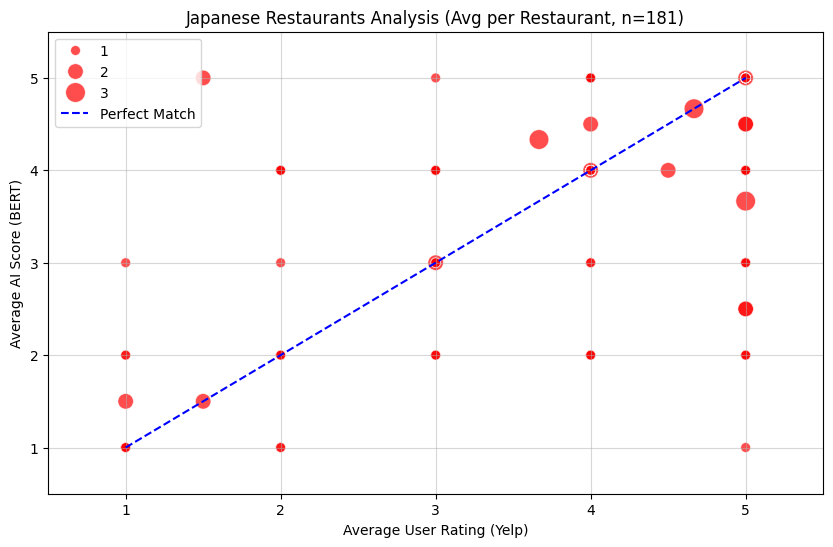

In [108]:
plt.figure(figsize=(10, 6))

sns.scatterplot(data=restaurant_group, x='rating', y='ai_score', 
                size='review_count', sizes=(50, 200), alpha=0.7, color='red')

plt.plot([1, 5], [1, 5], color='blue', linestyle='--', label='Perfect Match')

plt.title(f'Japanese Restaurants Analysis (Avg per Restaurant, n={len(restaurant_group)})')
plt.xlabel('Average User Rating (Yelp)')
plt.ylabel('Average AI Score (BERT)')
plt.legend()
plt.grid(True, alpha=0.5)
plt.xlim(0.5, 5.5)
plt.ylim(0.5, 5.5)
plt.show()

In [109]:
corr_jp = restaurant_group['rating'].corr(restaurant_group['ai_score'])
print(f"식당별 평균 점수 상관계수: {corr_jp:.4f}")

식당별 평균 점수 상관계수: 0.5866


식당별 평균 별점과 BERT 예측 점수 간의 상관계수는 0.5866으로 나타났다. 통계적으로 이는 뚜렷한 양의 상관관계에 해당한다. 비록 영어 데이터 검증 결과보든 낮지만, 별도의 추가 학습 없이 사전 학습된 모델을 바로 적용한 결과임을 감안할 때, 모델이 일본어 리뷰의 긍/부정 경향성을 유의미한 수즌으로 파악하고 있음을 시사한다.

앞선 영어 모델은 Zomato 식당 리뷰 데이터로 학습되어 식당 용어에 특화된 반면, 일본어 분석에 사용된 Multilingual BERT는 일반적인 텍스트로 학습된 범용 모델이다. 따라서, 식당 리뷰만의 특수한 문맥을 파악하는 데에는 한계가 있었다. 또한, 데이터의 모수의 차이에서도 기인하는데, 소규모 데이터이기 때문에 이상치의 영향을 더 크게 받은 것으로 보인다.

그러나, 최소한의 자원으로 0.6에 육박하는 상관관계를 확보할 수 있었고, 이는 보편적인 상관관계를 가정한 가설이 입증되는 대목이기도 하다. 또한, 이를 통해 다시 모델로 만족도 지수를 재산출할 수 있음을 확인할 수 있었다.